# Streaming

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [1]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

### Basic langgraph example of summarizing a chatbot conversation

In [2]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

In [3]:
# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)


# State
class State(MessagesState):
    summary: str


# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}


def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

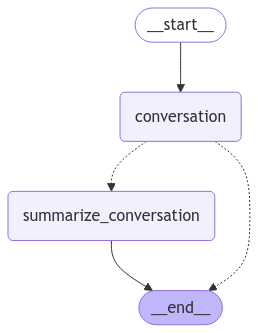

In [4]:
# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [5]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Run the graph
# Start conversation
for chunk in graph.stream(
    {"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"
):
    chunk["conversation"]["messages"].pretty_print()

================================== Ai Message ==================================

Hello Lance! How can I assist you today?


In [6]:
for chunk in graph.stream(
    {"messages": [HumanMessage(content="What is my name")]},
    config,
    stream_mode="updates",
):
    chunk["conversation"]["messages"].pretty_print()

================================== Ai Message ==================================

You mentioned that your name is Lance. How can I help you today?


Next we test with `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [7]:
# Start conversation, again with a different thread id to simulate a new conversation
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("---" * 25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
---------------------------------------------------------------------------


In [8]:
input_message = HumanMessage(content="What is my name")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("---" * 25)

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================ Human Message =================================

What is my name
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================ Human Message =================================

What is my name
================================== Ai Message ==================================

You mentioned that your name is Lance. How can I help you today?
---------------------------------------------------------------------------


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [9]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events(
    {"messages": [input_message]}, config, version="v2"
):
    print(
        f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}. data: {event['data']}"
    )

Node: . Type: on_chain_start. Name: LangGraph. data: {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={})]}}
Node: __start__. Type: on_chain_start. Name: __start__. data: {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={})]}}
Node: __start__. Type: on_chain_start. Name: _write. data: {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={})]}}
Node: __start__. Type: on_chain_end. Name: _write. data: {'output': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={})]}, 'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={})]}}
Node: __start__. Type: on_chain_start. Name: _write. data: {'input': {'messages': [HumanMessage(content='Tell me about the 49ers 

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [10]:
node_to_stream = "conversation"
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events(
    {"messages": [input_message]}, config, version="v2"
):
    # Get chat model tokens from a particular node
    if (
        event["event"] == "on_chat_model_stream"
        and event["metadata"].get("langgraph_node", "") == node_to_stream
    ):
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-9244ef37-e1ca-476a-b943-9a4f2fe9bdbf')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run-9244ef37-e1ca-476a-b943-9a4f2fe9bdbf')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run-9244ef37-e1ca-476a-b943-9a4f2fe9bdbf')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run-9244ef37-e1ca-476a-b943-9a4f2fe9bdbf')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run-9244ef37-e1ca-476a-b943-9a4f2fe9bdbf')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={}, id='run-9244ef37-e1ca-476a-b943-9a4f2fe9bdbf')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response_metadata={}, id='run-9244ef37-e1ca-476a-b943-9a4f2fe9bdbf')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, response_me

Better visibility of the graph

In [11]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events(
    {"messages": [input_message]}, config, version="v2"
):
    # Get chat model tokens from a particular node
    if (
        event["event"] == "on_chat_model_stream"
        and event["metadata"].get("langgraph_node", "") == node_to_stream
    ):
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area|.| They| compete| in| the| National| Football| League| (|NFL|)| as| a| member| of| the| league|'s| National| Football| Conference| (|N|FC|)| West| division|.| The| team| was| founded| in| |194|6| as| a| charter| member| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| and| joined| the| NFL| in| |194|9| when| the| leagues| merged|.

|###| Key| Points| about| the| |49|ers|:

|-| **|St|adium|**|:| The| |49|ers| play| their| home| games| at| Levi|'s| Stadium| in| Santa| Clara|,| California|,| which| they| moved| to| in| |201|4|.| Before| that|,| they| played| at| Cand|lestick| Park| in| San| Francisco|.

|-| **|Team| Colors|**|:| The| team's| colors| are| red|,| gold|,| and| white|.

|-| **|Champ|ionship|s|**|:| The| |49|ers| have| won| five| Super| Bowl| titles| (|X|VI|,| XIX|,| XX|III|,| XX|IV|,| and| XX|IX|),| with| their| most| successful| period| being| the|